In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt

In [2]:
print(os.path.getsize("..\data\Soil Profiles\Geomorphology\Geomorphology 250K.shp"))

1972867100


In [3]:
geomorph = gpd.read_file("..\data\Soil Profiles\Geomorphology\Geomorphology 250K.shp").to_crs("EPSG:4326")

geomorph["geometry"] = geomorph["geometry"].simplify(
    tolerance=0.001, 
    preserve_topology=True
)


print(geomorph.head())
print(geomorph.columns)

   OBJECTID   SHAPE_LENG DESCRIPTIO         LEGEND_SHO  \
0    279993  1199.627835       Pond  Waterbodies-Other   
1    278856   381.655309       Pond  Waterbodies-Other   
2    279771   606.793952       Pond  Waterbodies-Other   
3    279528   358.116639       Pond  Waterbodies-Other   
4    278815   452.750493       Pond  Waterbodies-Other   

                                            geometry  
0  POLYGON ((83.061 20.295, 83.062 20.295, 83.06 ...  
1  POLYGON ((83.059 20.257, 83.059 20.258, 83.06 ...  
2  POLYGON ((83.058 20.288, 83.057 20.289, 83.058...  
3  POLYGON ((83.057 20.281, 83.057 20.28, 83.056 ...  
4  POLYGON ((83.057 20.255, 83.057 20.256, 83.057...  
Index(['OBJECTID', 'SHAPE_LENG', 'DESCRIPTIO', 'LEGEND_SHO', 'geometry'], dtype='object')


In [4]:
states = gpd.read_file("..\data\Soil Profiles\india_states\gadm41_IND_1.json").to_crs("EPSG:4326")

gm_state = gpd.sjoin(geomorph, states, how="inner", predicate="intersects")
gm_state["area_km2"] = gm_state.geometry.to_crs(3857).area / 1e6


In [5]:
gm_state.columns

Index(['OBJECTID', 'SHAPE_LENG', 'DESCRIPTIO', 'LEGEND_SHO', 'geometry',
       'index_right', 'GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1',
       'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1',
       'area_km2'],
      dtype='object')

In [10]:
gm_state['LEGEND_SHO'].nunique()

51

In [7]:
gm_summary = (gm_state.groupby(["NAME_1", "LEGEND_SHO"])["area_km2"]
              .sum()
              .reset_index())

dominant = (gm_summary.sort_values(["NAME_1","area_km2"], ascending=[True,False])
            .drop_duplicates("NAME_1"))

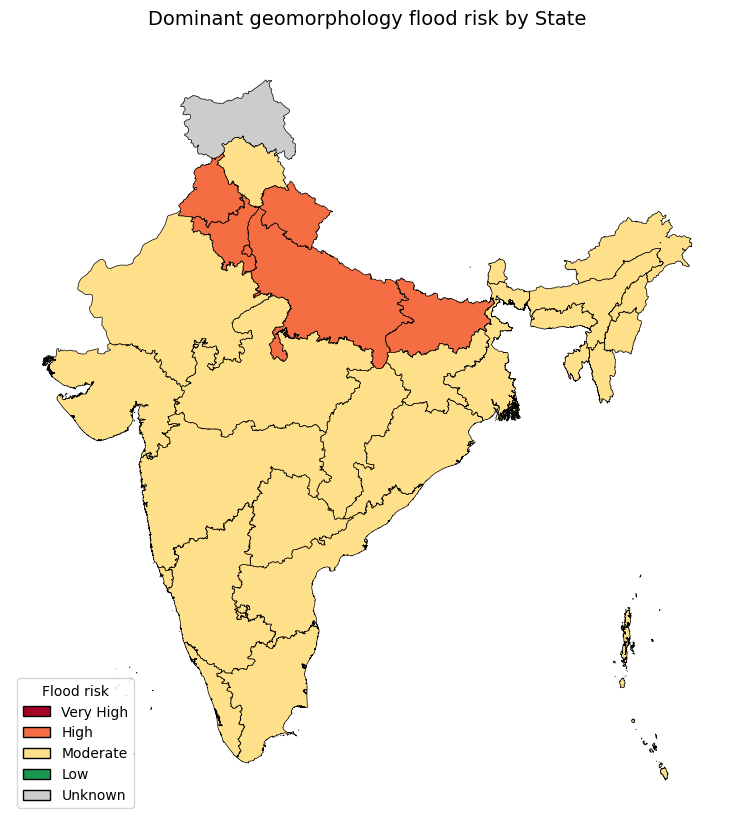

             NAME_1                             LEGEND_SHO gm_risk_cat  gm_risk_score
              Bihar                         Alluvial Plain        high            3.0
         Chandigarh                         Alluvial Plain        high            3.0
            Haryana                         Alluvial Plain        high            3.0
        Lakshadweep                          Coastal Plain        high            3.0
         NCTofDelhi                         Alluvial Plain        high            3.0
             Punjab                         Alluvial Plain        high            3.0
       UttarPradesh                         Alluvial Plain        high            3.0
        Uttarakhand                         Alluvial Plain        high            3.0
  AndamanandNicobar        Low Dissected Hills and Valleys    moderate            2.0
      AndhraPradesh             Pediment Pediplain Complex    moderate            2.0
   ArunachalPradesh Moderately Dissected Hills and Val

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

risk_cat = {
    # very high (8)
    "Flood Plain":"very_high",
    "Deltaic Plain":"very_high",
    "Lacustrine Plain":"very_high",
    "Lacustrine Delta":"very_high",
    "Lacustrine Swamp and Marsh":"very_high",
    "Waterbody - River":"very_high",
    "Waterbodies-Other":"very_high",
    "Glacial Lake and Nunatak":"very_high",

    # high (14)
    "Alluvial Plain":"high",
    "Coastal Plain":"high",
    "Bajada":"high",
    "Wadi":"high",
    "Aeolian Interdunal Depression and Playa":"high",
    "Glacial Outwash Plain":"high",
    "Kame Terrace":"high",
    "Mass Wasting Products":"high",
    "Dam and Reservoir":"high",
    "Anthropogenic terrain":"high",
    "Offshore Island":"high",
    "Coral Reef":"high",
    "Lake Island":"high",
    "Avalanche Chute":"high",

    # moderate (14)
    "Piedmont Slope":"moderate",
    "Pediment Pediplain Complex":"moderate",
    "Moderately Dissected Hills and Valleys":"moderate",
    "Low Dissected Hills and Valleys":"moderate",
    "Highly Dissected Hills and Valleys":"moderate",
    "Moderately Dissected Plateau":"moderate",
    "Low Dissected Plateau":"moderate",
    "Highly Dissected Plateau":"moderate",
    "Lacustrine Terrain":"moderate",
    "Quarry and Mine Dump":"moderate",
    "Glacial Terrain":"moderate",
    "Glacial Valley":"moderate",
    "Glacial Moraine":"moderate",
    "Sea Stacks":"moderate",
    "Snow Cover":"moderate",
    "Glacial Cirque- Arete- Horn":"moderate",

    # low (14)
    "Aeolian Sand Dune":"low",
    "Aeolian dune complex":"low",
    "Aeolian Sand Sheet":"low",
    "Aeolian Plain":"low",
    "Desert Pavement":"low",
    "Hamada":"low",
    "Impact Crater":"low",
    "Impact Crater Basin":"low",
    "Volcanic Cone and Crater":"low",
    "Lava Flow":"low",
    "Salt Pan":"low",

    # unknown (1)
    "Unmapped":"unknown",
}

risk_score = {"low":1, "moderate":2, "high":3, "very_high":4, "unknown":None}

# dominant has one row per state with columns: NAME_1, LEGEND_SHO (dominant class)
dom = dominant[["NAME_1","LEGEND_SHO"]].copy()
dom["gm_risk_cat"] = dom["LEGEND_SHO"].map(risk_cat).fillna("unknown")
dom["gm_risk_score"] = dom["gm_risk_cat"].map(risk_score)

# join to dissolved states for mapping (states_diss has NAME_1 + geometry)
states_ae = states.to_crs(7755).copy()
states_ae["geometry"] = states_ae.buffer(0)
states_diss = states_ae.dissolve(by="NAME_1", as_index=False)
states_rank = states_diss.merge(dom, on="NAME_1", how="left")

# plot
palette = {
    "very_high":"#a50026",
    "high":"#f46d43",
    "moderate":"#fee08b",
    "low":"#1a9850",
    "unknown":"#cccccc",
}
states_rank["__color__"] = states_rank["gm_risk_cat"].map(palette).fillna("#cccccc")

fig, ax = plt.subplots(figsize=(10,10))
states_rank.plot(ax=ax, color=states_rank["__color__"], edgecolor="black", linewidth=0.5)
ax.set_axis_off()

handles = [Patch(facecolor=palette[k], edgecolor="black", label=k.replace("_"," ").title())
           for k in ["very_high","high","moderate","low","unknown"]]

ax.set_title("Dominant geomorphology flood risk by State", fontsize=14, pad=15)
ax.legend(handles=handles, title="Flood risk", loc="lower left")
plt.show()

# optional: table sorted by highest risk
table = states_rank[["NAME_1","LEGEND_SHO","gm_risk_cat","gm_risk_score"]].sort_values(
    ["gm_risk_score","NAME_1"], ascending=[False, True]
)
print(table.to_string(index=False))

In [8]:
dominant.to_csv("..\data\dominant_geomorphology_by_state.csv", index=False)